In [13]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [14]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import  Parameter, Parameters, Covariance , Fit
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#from my_dataset_maps_20_e import MapDatasetNuisanceE gets imported in Dataset_Creation!
#from  my_fit_20 import Fit
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Eff_area"
)
import my_dataset_core_20_e , my_fit_20_e
from Dataset_Creation_e_dependent import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : GoRdBOST 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

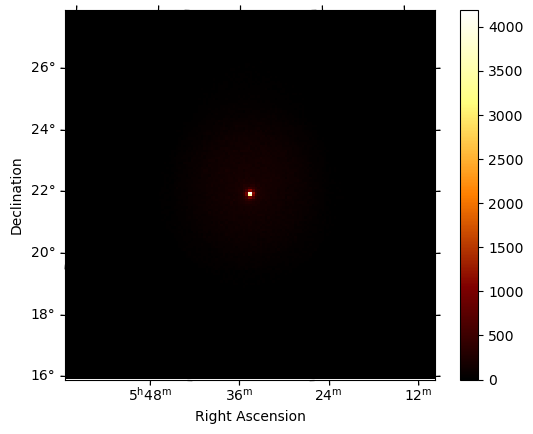

In [15]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Single Cases

In [16]:
shifts =[0.08/24] # 4e-3

tilts = [0.1]

sigma = [tilts[0], shifts[0]]
rnd = False

sys_ = sys_dataset(dataset_asimov = dataset_asimov,
                   tilt = tilts[0], 
                   shift = shifts[0] ,
                   rnd = rnd)
dataset_input = sys_.create_dataset()



In [17]:
datasets = []
datasets_N = []

for i, shift in enumerate(shifts):
    print(i, shift)
    sys_ = sys_dataset(dataset_asimov = dataset_asimov,
                   tilt = tilts[i], 
                   shift = shift ,
                   rnd = rnd)
    dataset = sys_.create_dataset()
    datasets.append(dataset)

    dataset_N = sys_.create_dataset_N(sigma)
    datasets_N.append(dataset_N)
    

0 0.0033333333333333335


In [18]:
%%time
for i, shift in enumerate(shifts):
    print(i, shift)
    fit = Fit(store_trace=False)
    result = fit.run([datasets[i]])


0 0.0033333333333333335
CPU times: user 7.6 s, sys: 38.8 ms, total: 7.64 s
Wall time: 7.66 s


In [19]:
datasets_N[0].N_parameters['effareatilt'].frozen = True#.to_table()

In [20]:
%%time
for i, shift in enumerate(shifts):
    fit_N = my_fit_20_e.Fit(store_trace=False)
    result_N = fit_N.run([datasets_N[i]])
    print(i, shift, datasets_N[i].N_parameters.value)


0 0.0033333333333333335 [0.         0.12940585]
CPU times: user 3min 18s, sys: 15.5 s, total: 3min 34s
Wall time: 3min 34s


In [21]:
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
import my_dataset_core_20
from  my_dataset_core_20 import Datasets as Datasets_N

dd = Datasets_N([datasets_N[0]])
dd.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
object,str12,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,4.0093e+00,,1.156e-02,nan,nan,False,False,
spectral,amplitude,2.9467e-09,cm-2 s-1 TeV-1,1.256e-11,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spatial,lon_0,8.3631e+01,deg,0.000e+00,nan,nan,True,False,
spatial,lat_0,2.2018e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,
spatial,sigma,2.4367e+00,deg,8.933e-03,0.000e+00,nan,False,False,
spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,
spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,
spectral,norm,3.4088e-03,,4.711e-05,nan,nan,False,True,


## Correlation

In [22]:
from  my_fit_20_e import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute):
    parameters = Parameters.from_stack([datasets_compute.models.parameters, 
                                        datasets_compute.N_parameters])
    parameters = parameters.free_parameters
    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )

        #covariance = covariance.get_subcovariance(datasets_compute.models.parameters)
    return covariance

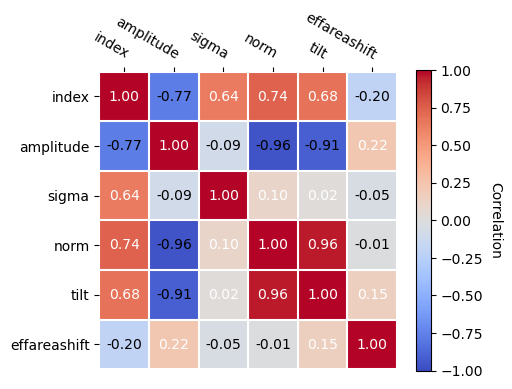

In [23]:
covariance  = covariance_(fit_N, datasets_N[0])
covariance.plot_correlation()


#eff_area_error = np.sqrt(covariance.get_subcovariance([datasets_N[0].N_parameters[0]]))
#print(eff_area_error)
fig = plt.gcf()
fig.savefig("plots/3_corr_matrix.png")